From work on #115, I found that #112 introduced color burst adjustment errors

In [1]:
%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys


import json

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

import lddecode_core as ldd

# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [2]:
matplotlib.rc('figure', figsize=(20, 12))

In [3]:
def write_json(ldd, outname):
    jsondict = ldd.build_json(ldd.curfield)
    
    fp = open(outname + '.tbc.json.tmp', 'w')
    json.dump(jsondict, fp, indent=4)
    fp.write('\n')
    fp.close()
    
    os.rename(outname + '.tbc.json.tmp', outname + '.tbc.json')


Original (broken) version in 2/17/19 commit c7f0f90  

In [22]:
from lddecode_core import *

outname = 'devbook'
system = 'NTSC'
foutput = False
loader = load_packed_data_4_40

# I found that the frame 15492 of Mammoth Mountain Adventure - with full/overdone MTF -
# had many single-line TBC errors, so I used that at first...

filename = '/home/cpage/ldtest/he010_cbar.lds'
firstframe = 0
req_frames = 2

#filename = '/home/cpage/ldtest/ggv_6000_cbar.lds'
firstframe = 0
req_frames = 2

ldd = LDdecode(filename, outname, loader, system=system, digital_audio=True)
ldd.roughseek(firstframe)
ldd.blackIRE = 0

#ldd.rf.mtf_mult = 0.35

fields = []
for i in range(0, req_frames * 2):
    fields.append(ldd.readfield())
    #ldd.processfield(fields[-1])

write_json(ldd, outname)

file frame 0 CAV frame 47748
file frame 1 CAV frame 47749


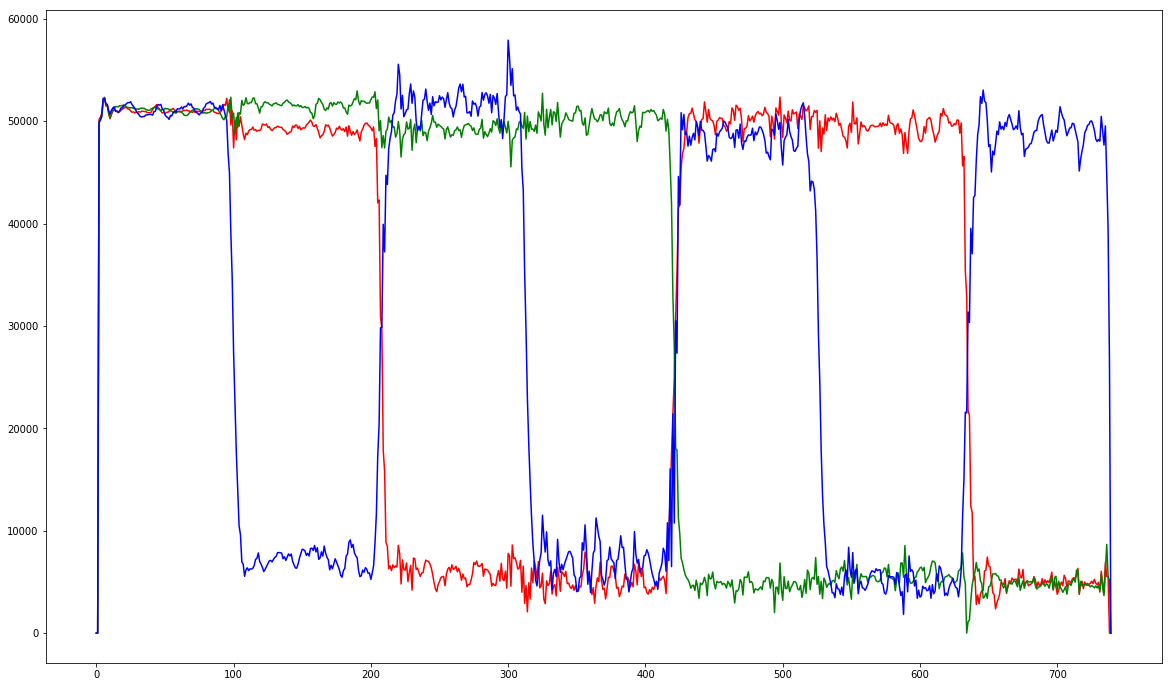

In [23]:
os.system('tools/ld-chroma-decoder/ld-chroma-decoder {0}.tbc {0}.rgb'.format(outname))
with open(outname + '.rgb', 'rb') as fd:
    inbuf = fd.read()
    
rgb = np.frombuffer(inbuf, 'uint16', len(inbuf) // 2)

imgsize = 740*486*3
rgba = rgb.reshape((int(len(rgb)/imgsize), 486, 740*3))

l = rgba[1][200]

plt.plot(l[0::3], color='r')
plt.plot(l[1::3], color='g')
plt.plot(l[2::3], color='b')

In [13]:
ldd.fieldinfo

[{'isFirstField': True,
  'syncConf': 75,
  'seqNo': 1,
  'audioSamples': 802,
  'diskLoc': 0.1,
  'medianBurstIRE': 15.594256115890206,
  'dropOuts': {'fieldLine': [], 'startx': [], 'endx': []},
  'fieldPhaseID': 3,
  'decodeFaults': 0},
 {'isFirstField': False,
  'syncConf': 75,
  'seqNo': 2,
  'audioSamples': 800,
  'diskLoc': 1.1,
  'medianBurstIRE': 15.71261756485676,
  'dropOuts': {'fieldLine': [], 'startx': [], 'endx': []},
  'fieldPhaseID': 4,
  'decodeFaults': 0,
  'vitsMetrics': {'ntscLine19Burst0IRE': 15.980481863775044,
   'ntscLine19Burst70IRE': 15.016206743484029,
   'blackLineF1PreTBCIRE': -0.47380190377019565,
   'blackLineF2PreTBCIRE': 1.260534580005563,
   'blackLineF1PostTBCIRE': 0.4171277995311229,
   'blackLineF2PostTBCIRE': 0.5075475109736658,
   'blackLineF1PSNR': 37.46598500329134,
   'blackLineF2PSNR': 37.65241851729374},
  'frameNumber': 5998},
 {'isFirstField': True,
  'syncConf': 75,
  'seqNo': 3,
  'audioSamples': 802,
  'diskLoc': 2.1,
  'medianBurstIRE': 

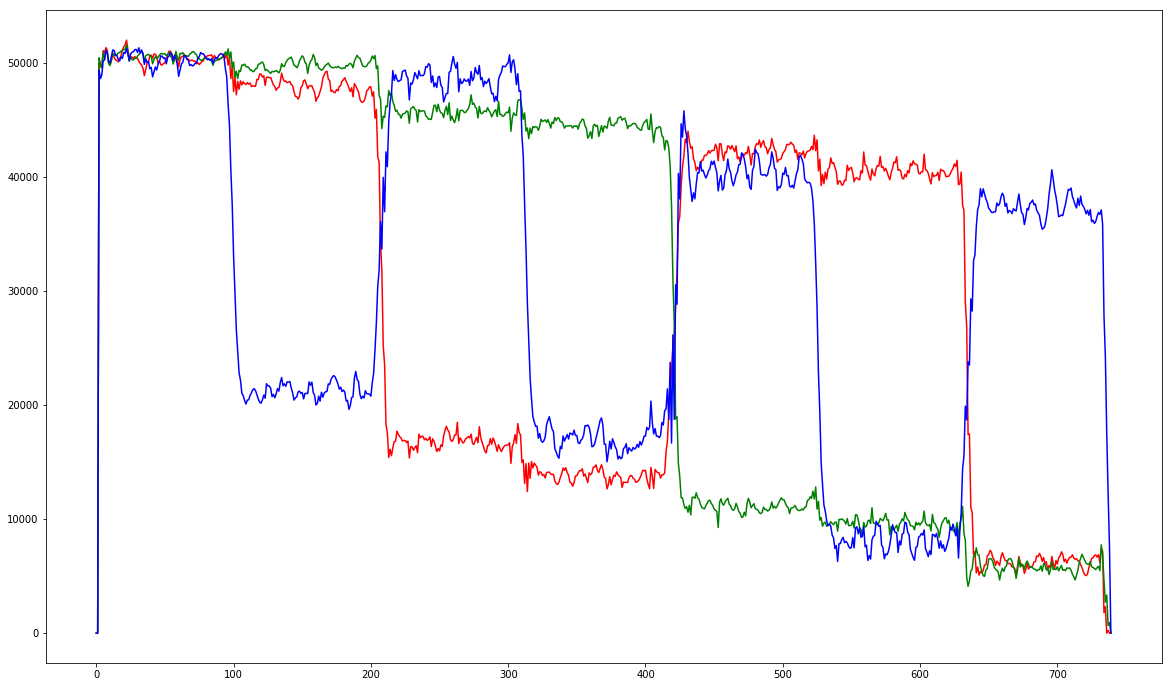

In [9]:
l = rgba[1][201]

plt.plot(l[0::3], color='r')
plt.plot(l[1::3], color='g')
plt.plot(l[2::3], color='b')

Adding the post-TBC lines shows that the phase offsets are a bit worse than rev4 (which is 448), so I'm not sure what's going on yet...

393.78948297281886

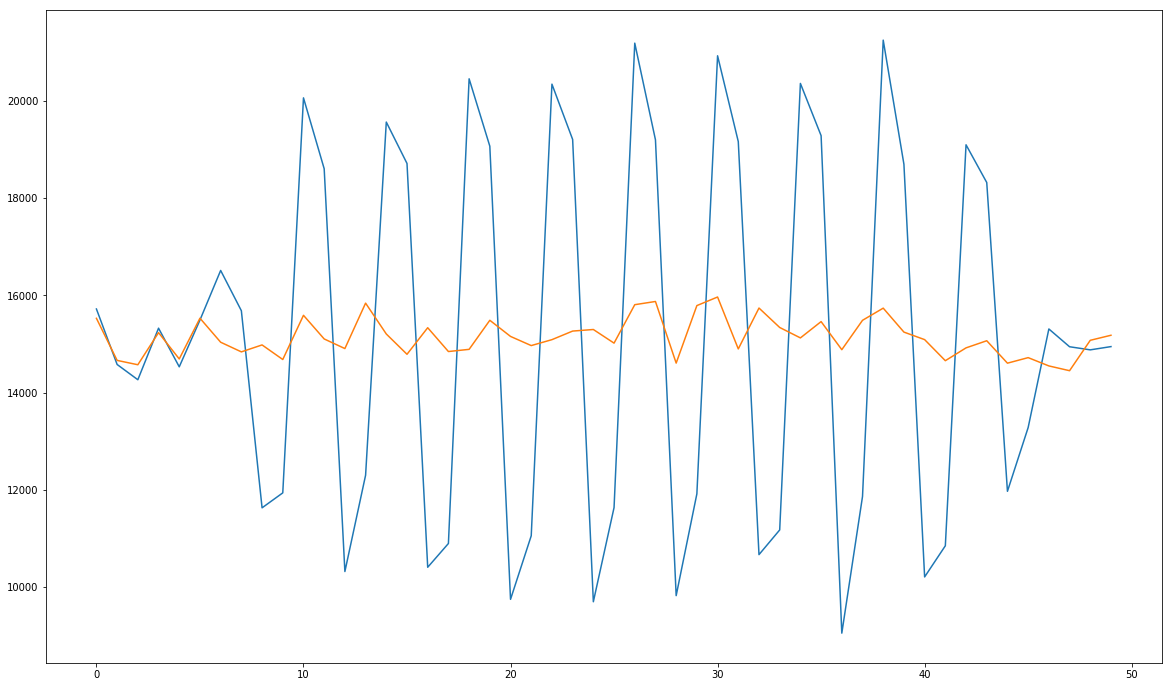

In [10]:
f2 = fields[2]
wl_slice = f2.lineslice_tbc(101, 4.9, 3.5)
s1 = copy.deepcopy(f2.dspicture[wl_slice])
plt.plot(f2.dspicture[wl_slice])

f2 = fields[2]
wl_slice = f2.lineslice_tbc(102, 4.9, 3.5)
plt.plot((s1 + f2.dspicture[wl_slice]) / 2)

#ldd.calcsnr(f2, wl_slice), np.mean(f2.output_to_ire(f2.dspicture[wl_slice]))
np.std((s1 + f2.dspicture[wl_slice]) / 2)

In [10]:

def compute_field_zc(f, lineinfo):
    m = []

    ds = f.downscale(final=False, lineinfo=lineinfo, wow=True)
    for l in range(11, 200):
        wl_slice = f.lineslice_tbc(l, 0, 9)
        s1 = copy.deepcopy(ds[0][wl_slice])

        i = 75
        zc = 75

        zcs = []

        while i < len(s1):
            if s1[i] < f.rf.iretohz(-10):
                zc = calczc(s1, i, f.rf.iretohz(0))
                if zc is not None:
                    zcs.append(zc)
                    #print(i, zc)
                    i = int(zc) + 1
                else:
                    i += 1
            else:
                i += 1

        m.append(np.mean([np.round(z) - z for z in zcs[1:-1]]))

    return m

m1 = compute_field_zc(fields[2], lineinfo=fields[2].linelocs3)
m2 = compute_field_zc(fields[3], lineinfo=fields[3].linelocs3)


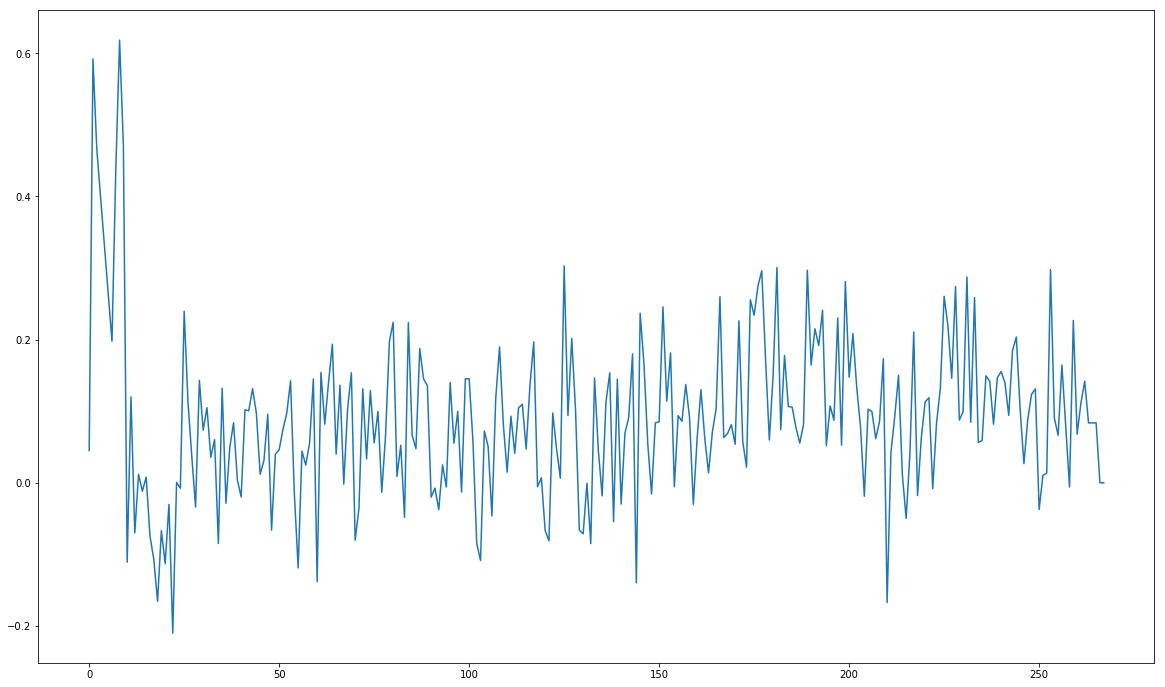

In [11]:
plt.plot(np.array(fields[2].linelocs3) - np.array(fields[2].linelocs2))

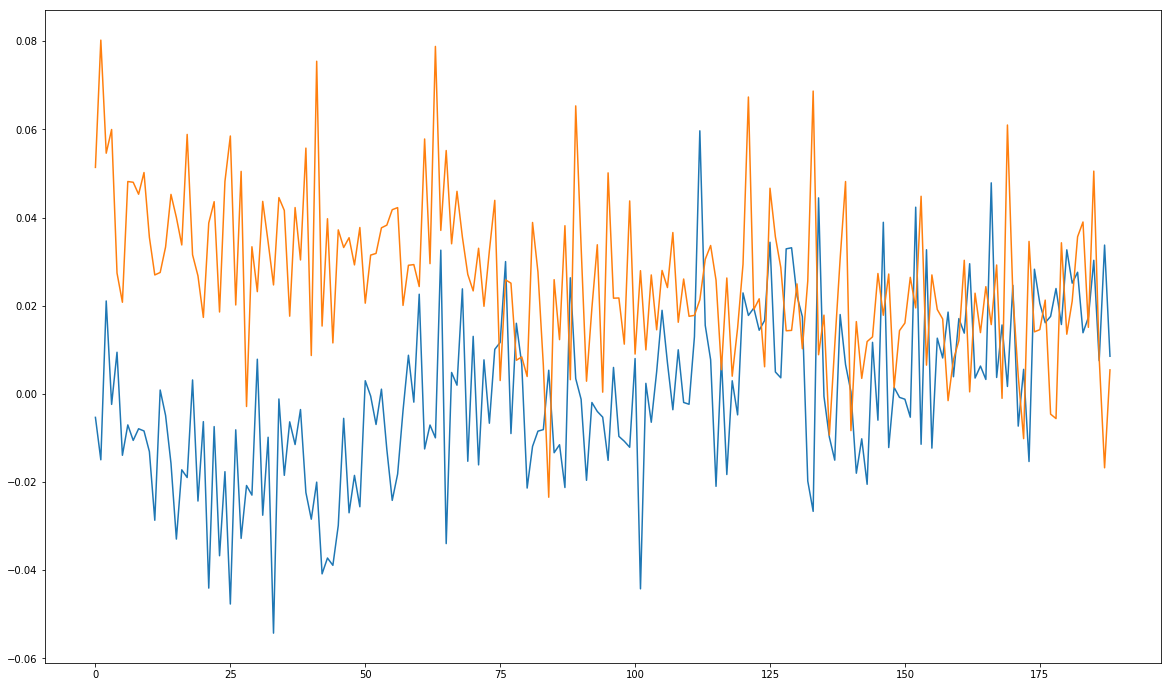

In [12]:
plt.plot(m1)
plt.plot(m2)

In [16]:
plt.plot(np.diff(f.linelocs3[:250]))

NameError: name 'f' is not defined

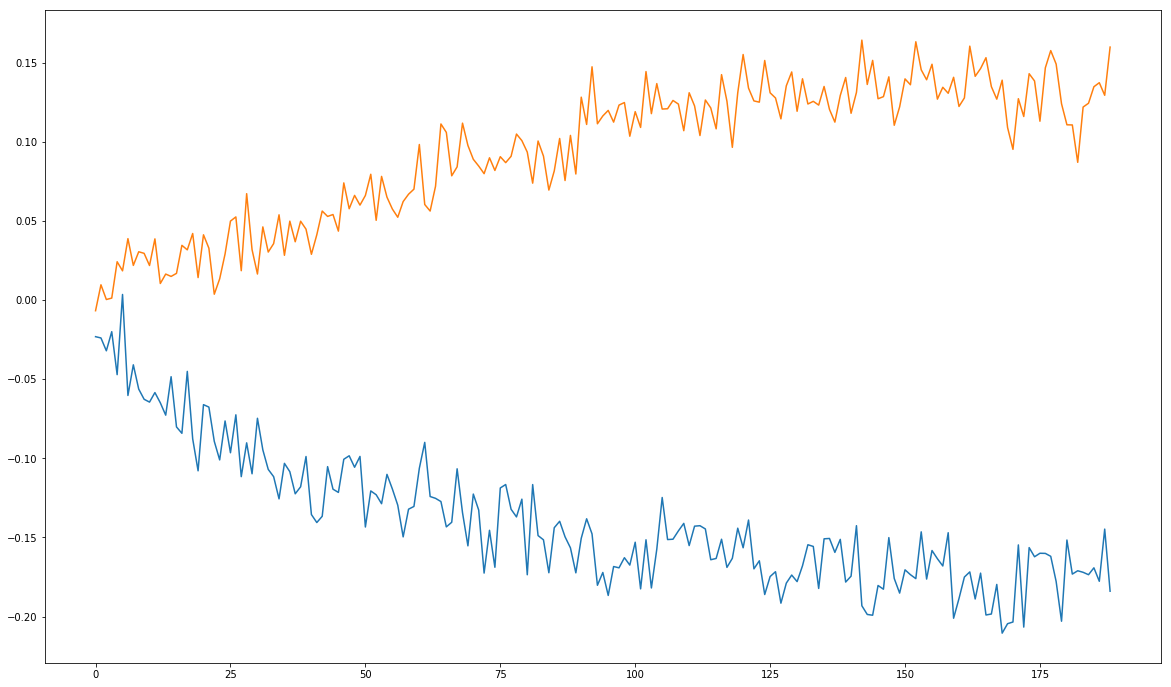

In [115]:
plt.plot(m)
plt.plot(m1)

In [113]:
m1 = m.copy()

In [110]:
np.std(m)

0.04366518443946334

In [57]:
def refine_linelocs_burst(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs2

    linelocs_adj = linelocs.copy()
    burstlevel = np.zeros_like(linelocs_adj, dtype=np.float32)

    valid, zc_bursts, field14, burstlevel, badlines = self.compute_burst_offsets(linelocs_adj)

    if not valid or self.burst90 == True:
        #print("WARNING: applying 90 degree line adjustment for burst processing")
        self.burst90 = True
        linelocs_adj = [l + (self.rf.linelen * (.25 / 227.5)) for l in linelocs_adj]
        valid, zc_bursts, field14, burstlevel, badlines = self.compute_burst_offsets(linelocs_adj)
    else:
        self.burst90 = False

    adjs = {}

    for l in range(1, 9):
        self.linebad[l] = True

    # compute the adjustments for each line but *do not* apply, so
    # outliers can be bypassed
    for l in range(0, 266):
        if self.linebad[l]:
            continue

        edge = not ((field14 and (l % 2)) or (not field14 and not (l % 2)))

        if not (np.isnan(linelocs_adj[l]) or len(zc_bursts[l][edge]) == 0 or self.linebad[l] or badlines[l]):
            if l > 0:
                lfreq = self.rf.freq * (((self.linelocs2[l+1] - self.linelocs2[l-1]) / 2) / self.rf.linelen)
            elif l == 0:
                lfreq = self.rf.freq * (((self.linelocs2[l+1] - self.linelocs2[l-0]) / 1) / self.rf.linelen)
            elif l >= 262:
                lfreq = self.rf.freq * (((self.linelocs2[l+0] - self.linelocs2[l-1]) / 1) / self.rf.linelen)

            adjs[l] = -(np.median(zc_bursts[l][edge]) * lfreq * (1 / self.rf.SysParams['fsc_mhz']))
            print(l, zc_bursts[l][edge], lfreq, adjs[l])

    adjs_median = np.median([adjs[a] for a in adjs])
    #print(adjs_median)

    for l in range(0, 266):
        if l in adjs and inrange(adjs[l] - adjs_median, -2, 2):
            linelocs_adj[l] += adjs[l]
        else:
            linelocs_adj[l] += adjs_median
            self.linebad[l] = True

    self.field14 = field14

    return linelocs_adj, burstlevel#, adjs

rv = refine_linelocs_burst(f)

0 [-0.02936822783448534, -0.029690693605903817, -0.027023155676833, -0.024167340465673703, -0.030842694948781002, -0.033683829127316045, -0.031211732936363035, -0.03124900053423829, -0.027822610027723016] 39.98010447808138 0.3316166947631266
9 [-0.04933006495799219, -0.04768682107353328, -0.04937042161509808, -0.05621154987995425, -0.05900254270946448, -0.06504941471124326, -0.06263942776659448, -0.06463136777388101, -0.0650609720256412] 39.996269735685004 0.6592685141914711
10 [-0.016138251057753905, -0.029732356429590823, -0.02587997452697266, -0.024735162512264708, -0.024882202402512377, -0.03039853577104168, -0.030881563333405637, -0.03219138429118118, -0.026585424732864738] 39.99477247776556 0.2970427466050171
11 [-0.013954176447878552, -0.015199759230128507, -0.017607334494620375, -0.018256922173751633, -0.01894136813390901, -0.02695118938516572, -0.026509166326768252, -0.02573033387007584, -0.026290059383427433] 39.991334102935745 0.21161641639386444
12 [-0.03866728989465429, -0